# NAS based on NASBench-101

In this colab, we applied random search(RS), evolutionary algorithm(EA) and Estimator-based research(EST) to search in NASBench. The opeartions of vertices and edges are all from [**NAS-Bench-101: Towards Reproducible Neural Architecture Search**](https://arxiv.org/abs/1902.09635) and the random search and evolution part of this colab is modified based on https://github.com/google-research/nasbench.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load NASBench library and dataset

In [ ]:
# This code was written in TF 1.12 but should be supported all the way through
# TF 1.15. Untested in TF 2.0+.
%tensorflow_version 1.x

# Download the full raw data

!curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

# Clone and install the code and dependencies.

!git clone https://github.com/google-research/nasbench
!pip install ./nasbench

# Initialize the NASBench object which parses the raw data into memory
from nasbench import api
nasbench = api.NASBench('nasbench_full.tfrecord')

TensorFlow 1.x selected.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1989M  100 1989M    0     0  61.3M      0  0:00:32  0:00:32 --:--:-- 67.1M
Cloning into 'nasbench'...
remote: Enumerating objects: 96, done.
remote: Total 96 (delta 0), reused 0 (delta 0), pack-reused 96
Unpacking objects: 100% (96/96), done.
Processing ./nasbench
  Created wheel for nasbench: filename=nasbench-1.0-cp37-none-any.whl size=46788 sha256=35ffaf1ef11277d0266d0f2c48ddc54b17b830da38d0c741c68dfa6d74b12ddf
  Stored in directory: /tmp/pip-ephem-wheel-cache-dwgs45q5/wheels/4b/19/99/1d5fdfe30f8b16fab91e900808f4f7e5adc38e602c84970ad5
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=ff6f07cae99a7c4407e86b06e39d9262ed9d2fa02849ca3c3edc5998e0ded27d
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully bui

In [ ]:
# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1)/2   # Upper triangular matrix
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix
SELECT_OPS = [INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT] # operation fro vertices are fixed
SELECT_OPS_1 = [INPUT, CONV1X1, CONV1X1, CONV1X1, CONV1X1, CONV1X1, OUTPUT]
SELECT_OPS_2 = [INPUT, MAXPOOL3X3, MAXPOOL3X3, MAXPOOL3X3, MAXPOOL3X3, MAXPOOL3X3, OUTPUT]

## Search methods definition:

### 1. Random Search

In [ ]:
def random_spec(select):
  """Returns a random valid spec."""
  while True:
    # random connection
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = select
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec

def run_random_search(max_time_budget=5e6, ops = SELECT_OPS):
  """Run a single roll-out of random search to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  while True:
    spec = random_spec(ops)
    data = nasbench.query(spec)

    # select models only based on validation accuracy
    # test accuracy is used only for comparing different search trajectories.
    if data['test_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    if time_spent > max_time_budget:
      # Break the first time we exceed the budget.
      break

  return times, best_valids, best_tests, spec

### 2. Evolutionary algorithm

In [ ]:
def mutate_spec(old_spec, ops, mutation_rate=1.0):
  """Computes a valid mutated spec from the old_spec."""
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix)
    new_ops = copy.deepcopy(old_spec.original_ops)

    # In expectation, V edges flipped (note that most end up being pruned).
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          new_matrix[src, dst] = 1 - new_matrix[src, dst]
        
    new_spec = api.ModelSpec(new_matrix, new_ops)
    if nasbench.is_valid(new_spec):
      return new_spec

def random_combination(iterable, sample_size):
  """Random selection from itertools.combinations(iterable, r)."""
  pool = tuple(iterable)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

def run_evolution_search(max_time_budget=5e6,
                         population_size=50,
                         tournament_size=10,
                         mutation_rate=1.0, ops = SELECT_OPS):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  for _ in range(population_size):
    spec = random_spec(ops)
    data = nasbench.query(spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    population.append((data['test_accuracy'], spec))

    if data['test_accuracy'] > best_valids[-1]:
      best_valids.append(data['test_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  # After the population is seeded, proceed with evolving the population.
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, ops, mutation_rate)

    data = nasbench.query(new_spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['test_accuracy'], new_spec))
    population.pop(0)

    if data['test_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    if time_spent > max_time_budget:
      break

  return times, best_valids, best_tests, best_spec
  

### 3. Estimator-based search
For estimator based search we have calculated the edge-accuracy probability function based on the auto shrink method. Code for generating the results can be found in the Auto-Shrink file in our project

In [ ]:
def random_generate_medges_matrix(m):
    zero_matrix = np.zeros((NUM_VERTICES, NUM_VERTICES), dtype=np.int)
    positions = []
    for i in range(0, NUM_VERTICES):
        for j in range(i+1, NUM_VERTICES):
            positions.append(i*NUM_VERTICES+j)
            
    edges = np.random.choice(positions, m, replace = False)
    for edge in edges:
        zero_matrix[edge//NUM_VERTICES][edge%NUM_VERTICES] = 1
    
    return zero_matrix

def random_generate_medges_space(m, ops):
    while True:
        matrix = random_generate_medges_matrix(m)
        space = api.ModelSpec(matrix, ops)
        
        if nasbench.is_valid(space):
            return space

def fix_edges_random_search(m, ops, max_time_budget=5e6):
    nasbench.reset_budget_counters()
    times, best_valids, best_tests = [0.0], [0.0], [0.0]
    
    while True:
        space = random_generate_medges_space(m, ops)
        data = nasbench.query(space)
        
        if data['test_accuracy']>best_valids[-1]:
            best_valids.append(data['validation_accuracy'])
            best_tests.append(data['test_accuracy'])
        else:
            best_valids.append(best_valids[-1])
            best_tests.append(best_tests[-1])
        
        time_spent,_ = nasbench.get_budget_counters()
        times.append(time_spent)
        if time_spent > max_time_budget:
            break
            
        
    return times, best_valids, best_tests, space

## Training
We applied random space search without random seed for the final results, passing in random seed if a repeated results need to observed.

In [ ]:
# Run random search, evolution search and estimotor-based search 10 times each. 
# Each run would have taken days of compute to actually train and evaluate if the dataset were not precomputed.
TIME_BUDGET = int(5e6)
random_data = []
random_data1 = []
random_data2 = []
evolution_data = []
estimator_data = []
for repeat in range(10):
  print('Running repeat %d' % (repeat + 1))
  # times, best_valid, best_test, spec_est = fix_edges_random_search(9, SELECT_OPS_1, max_time_budget=TIME_BUDGET)
  # estimator_data.append((times, best_valid, best_test, spec_est))

  times, best_valid, best_test, spec_rs = run_random_search(max_time_budget=TIME_BUDGET, ops = SELECT_OPS)
  random_data.append((times, best_valid, best_test, spec_rs))

  # comment out following four lines if you are not abserving the different search spaces
  times, best_valid, best_test, spec_rs = run_random_search(max_time_budget=TIME_BUDGET, ops = SELECT_OPS_1)
  random_data1.append((times, best_valid, best_test, spec_rs))

  times, best_valid, best_test, spec_rs = run_random_search(max_time_budget=TIME_BUDGET, ops = SELECT_OPS_2)
  random_data2.append((times, best_valid, best_test, spec_rs))

  # following are used for search using different search methods
  # times, best_valid, best_test, spec_evo = run_evolution_search(max_time_budget=TIME_BUDGET, ops = SELECT_OPS)
  # evolution_data.append((times, best_valid, best_test, spec_evo))

  # times, best_valid, best_test, spec_evo = run_evolution_search(max_time_budget=TIME_BUDGET)
  # autoshrink_data.append((times, best_valid, best_test, spec_evo))

Running repeat 1
Running repeat 2
Running repeat 3
Running repeat 4
Running repeat 5
Running repeat 6
Running repeat 7
Running repeat 8
Running repeat 9
Running repeat 10


## Plotting and choosing structures

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
for times, best_valid, best_test, spec in random_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.8, 0.96)
plt.grid()
plt.title('Random search(red=validation, blue=test)')

plt.subplot(1, 3, 2)
for times, best_valid, best_test, spec in evolution_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Evolution search(red=validation, blue=test)')

plt.subplot(1, 3, 3)
for times, best_valid, best_test, spec in estimator_data:
  plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
  plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

plt.ylabel('accuracy')
plt.xlabel('time spent (seconds)')
plt.ylim(0.92, 0.96)
plt.grid()
plt.title('Estimator-based search(red=validation, blue=test)')

# plt.savefig("accuracies_est9_all1.jpg")

10


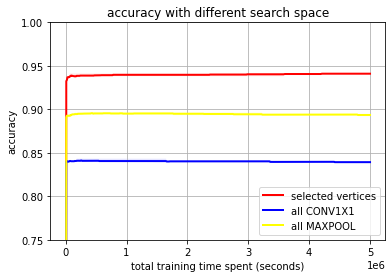

In [ ]:
# Compare the mean test accuracy along with error bars.
def plot_data(data, color, label, gran=10000, max_budget=5000000):
  """Computes the mean and IQR fixed time steps."""
  xs = range(0, max_budget+1, gran)
  mean = [0.0]
  per25 = [0.0]
  per75 = [0.0]
  
  repeats = len(data)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget+1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(data[repeat][0]) and 
             data[repeat][0][pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = data[repeat][0][pointers[repeat]-1]
      prev_test = data[repeat][2][pointers[repeat]-1]
      next_time = data[repeat][0][pointers[repeat]]
      next_test = data[repeat][2][pointers[repeat]]
      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_time - prev_time)) * (next_test - prev_test) + prev_test
      
      all_vals.append(cur_val)
      
    all_vals = sorted(all_vals)
    mean.append(sum(all_vals) / float(len(all_vals)))
    per25.append(all_vals[int(0.25 * repeats)])
    per75.append(all_vals[int(0.75 * repeats)])
      
    cur += gran
    
  plt.plot(xs, mean, color=color, label=label, linewidth=2)
  plt.fill_between(xs, per25, per75, alpha=0.1, linewidth=0, facecolor=color)

print(len(random_data))
plot_data(random_data, 'red', 'selected vertices', max_budget=TIME_BUDGET)
plot_data(random_data1, 'blue', 'all CONV1X1', max_budget=TIME_BUDGET)
plot_data(random_data2, 'yellow', 'all MAXPOOL', max_budget=TIME_BUDGET)
# plot_data(evolution_data, 'blue', 'evolution', max_budget=TIME_BUDGET)
# plot_data(estimator_data, 'yellow', 'estimator-based', max_budget=TIME_BUDGET)
plt.legend(loc='lower right')
plt.ylim(0.75, 1)
plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.title('accuracy with different search space')
plt.grid()
# plt.savefig("accuracy with different search space.jpg")

In [ ]:
def printStructure(alg_data):
  best = []
  final_best_valid = 0
  for times, best_valid, best_test, spec in alg_data:
    a = max(best_valid)
    idx = best_valid.index(a) 
    if final_best_valid < a:
      final_best_valid = a
      best_spec = spec
  print(final_best_valid)
  print(spec.original_matrix)
  print(spec.original_ops)
  print("\n")
  cell = api.ModelSpec(matrix=spec.original_matrix, ops=spec.original_ops)
  data = nasbench.query(cell)
  for k, v in data.items():
    print('%s: %s' % (k, str(v)))

In [ ]:
# print the best architeture found
print("rs:")
printStructure(random_data)

print("\nevo:")
printStructure(evolution_data)

print("\nest:")
printStructure(estimator_data)

rs:
0.8441506624221802
[[0 1 1 1 0 0 1]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'output']


module_adjacency: [[0 1 1 1 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]]
module_operations: ['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'output']
trainable_parameters: 2975370
training_time: 1534.679931640625
train_accuracy: 0.9881811141967773
validation_accuracy: 0.8399438858032227
test_accuracy: 0.8369390964508057

evo:
0.8441506624221802
[[0 1 1 0 0 1 1]
 [0 0 0 1 1 1 0]
 [0 0 0 0 1 1 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'output']


module_adjacency: [[0 1 1 1 1]
 [0 0 0 1 0]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 0 0]]
module_operations: ['input', 'conv1x1-bn-r